In [1]:
!pip install imbalanced-learn
!pip install lightgbm
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
import time as timer
from sklearn.inspection import permutation_importance
import seaborn as sn

In [3]:
filename = "healthcare-dataset-stroke-data.csv"
df = pd.read_csv(filename)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [5]:
missing_value = df.isnull().sum() / len(df) * 100
print(missing_value)
print("Missing values in BMI: {:.2f}%".format(missing_value['bmi']))
print("Data shape: {}".format(df.shape))

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64
Missing values in BMI: 3.93%
Data shape: (5110, 12)


In [6]:
#Replace missing BMI values with average BMI
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

# drop variable 'ID' because we don't really need it
df.drop(columns = 'id', axis = 1, inplace = True)

# validate there's no more missing values
missing_value = df.isnull().sum()/len(df)*100
print(missing_value)

print("Missing values in BMI: {}".format(missing_value['bmi']))
print("New shape of data: {}".format(df.shape))

gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64
Missing values in BMI: 0.0
New shape of data: (5110, 11)


In [7]:
print("Gender: {}".format(df['gender'].unique()))
print("Ever Married': {}".format(df['ever_married'].unique()))
print("Work Type: {}".format(df['work_type'].unique()))
print("Residence Type: {}".format(df['Residence_type'].unique()))
print("Smoking Status: {}".format(df['smoking_status'].unique()))

Gender: ['Male' 'Female' 'Other']
Ever Married': ['Yes' 'No']
Work Type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence Type: ['Urban' 'Rural']
Smoking Status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [8]:
#Create encoder for each categorical variable
label_gender = LabelEncoder()
label_married = LabelEncoder()
label_work = LabelEncoder()
label_residence = LabelEncoder()
label_smoking = LabelEncoder()

In [9]:
df['gender'] = label_gender.fit_transform(df['gender'])
df['ever_married'] = label_married.fit_transform(df['ever_married'])
df['work_type']= label_work.fit_transform(df['work_type'])
df['Residence_type']= label_residence.fit_transform(df['Residence_type'])
df['smoking_status']= label_smoking.fit_transform(df['smoking_status'])

df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


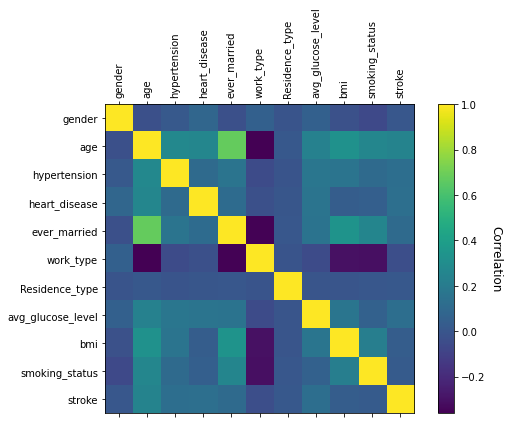

In [10]:
fig, ax = plt.subplots(figsize = (8, 6))
image = ax.matshow(df.corr())
ax.set_xticks(np.arange(df.shape[1]))
ax.set_yticks(np.arange(df.shape[1]))
ax.set_xticklabels(df.columns, rotation = 90)
ax.set_yticklabels(df.columns)

color_bar = ax.figure.colorbar(image, ax = ax)
color_bar.ax.set_ylabel("Correlation", rotation = -90, va = "bottom", fontsize = 12)
fig.tight_layout()
plt.show()

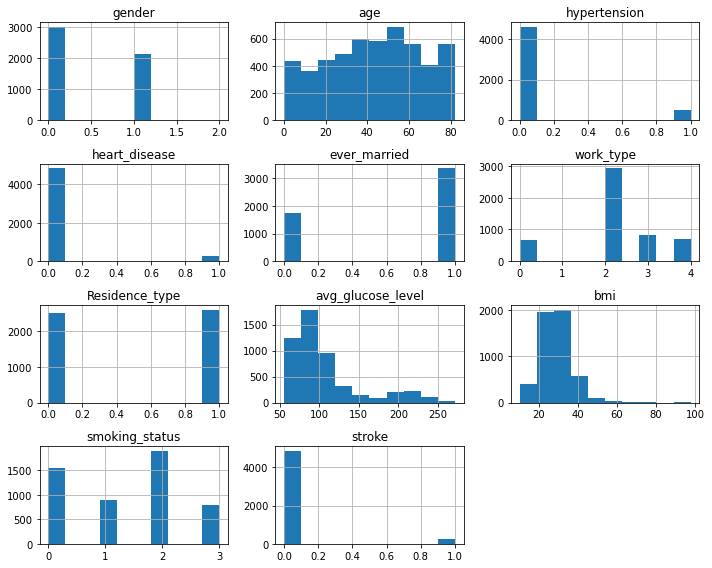

In [11]:
fig = df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

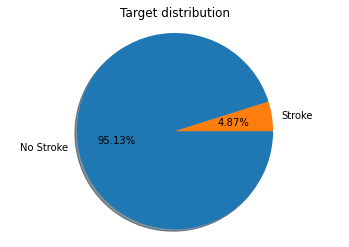

No Stroke Frequency: 4861
Stroke Frequency: 249


In [12]:
occurence = df['stroke'].value_counts()
target_names = ['No Stroke','Stroke']

fig, ax = plt.subplots()
ax.pie(occurence, labels = target_names, autopct = '%1.2f%%', shadow = True, startangle = 0, counterclock = False)

ax.axis('equal')
ax.set_title('Target distribution')
plt.show()

print("No Stroke Frequency: {}".format(occurence[0]))
print("Stroke Frequency: {}".format(occurence[1]))

In [13]:
#Use oversampling to avoid model bias
smote = SMOTE(sampling_strategy = 'minority')

#Fit to training data
X, y = smote.fit_resample(df.loc[:,df.columns != 'stroke'], df['stroke'])
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (9722, 10)
Shape of y: (9722,)


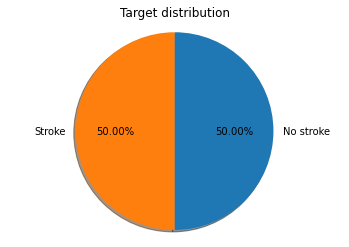

No Stroke: 4861
Stroke: 4861


In [14]:
_, occurence = np.unique(y, return_counts = True)
target_names = ['No stroke', 'Stroke']

fig, ax = plt.subplots()
ax.pie(occurence, labels = target_names, autopct = '%1.2f%%', shadow = True, startangle = 90, counterclock = False)

ax.axis('equal')
ax.set_title('Target distribution')
plt.show()

print("No Stroke: {}".format(occurence[0]))
print("Stroke: {}".format(occurence[1]))

In [15]:
def split_train_valid_test(X, y , test_size = 0.1, random_state = None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state, stratify = y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = test_size/(1-test_size), random_state = random_state, stratify = y_train)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

X_train, X_valid, X_test, y_train, y_valid, y_test = split_train_valid_test(X,y,test_size=0.1,random_state=42)
_, train_counts = np.unique(y_train, return_counts=True)
_, valid_counts = np.unique(y_valid, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)

In [16]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)
X_test_std = scaler.transform(X_test)

In [17]:
def sensitivity_specificity(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    #Sensitivity Equation from research
    sensitivity = TP / (TP + FN)    
    #Specificity Equation from research
    specificity = TN / (TN + FP)
    return sensitivity,specificity

In [18]:
start = timer.time()
svm_model = SVC(kernel = 'rbf', probability = True)
svm_model.fit(X_train_std, y_train)
end = timer.time()
print("SVC completed in {:.3f} seconds".format(end-start))

#Predict test set
y_svm = svm_model.predict(X_test_std)
y_svm_prob = svm_model.predict_proba(X_test_std)

SVC completed in 6.676 seconds


SVM Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       487
           1       0.85      0.89      0.87       486

    accuracy                           0.86       973
   macro avg       0.87      0.86      0.86       973
weighted avg       0.87      0.86      0.86       973

SVM Accuracy score: 0.864
SVM Precision score: 0.847
SVM Recall score: 0.889
SVM F1 score: 0.867
SVM Sensitivity score: 0.889
SVM Specitivity score: 0.840
SVM AUC score: 0.938

Confusion matrix for SVM:



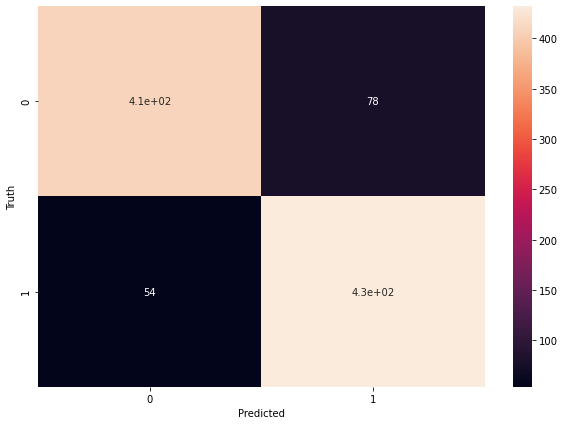

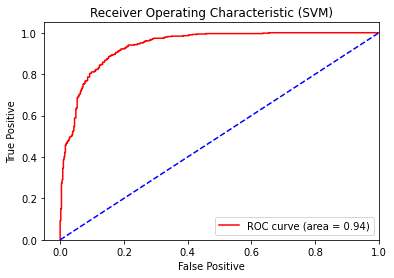

In [19]:
print("SVM Classification Report: \n{}".format(classification_report(y_test, y_svm)))

print("SVM Accuracy score: {:.3f}".format(accuracy_score(y_test, y_svm)))

precision_svm = precision_score(y_test, y_svm)
recall_svm = recall_score(y_test, y_svm)
F1_svm = f1_score(y_test, y_svm)

print("SVM Precision score: {:.3f}".format(precision_svm))
print("SVM Recall score: {:.3f}".format(recall_svm))
print("SVM F1 score: {:.3f}".format(F1_svm))

sens_svm, spec_svm = sensitivity_specificity(y_test, y_svm)
fpr, tpr, _ = roc_curve(y_test,  y_svm_prob[:, 1])
auc_svm = roc_auc_score(y_test, y_svm_prob[:, 1])

print("SVM Sensitivity score: {:.3f}".format(sens_svm))
print("SVM Specitivity score: {:.3f}".format(spec_svm))
print("SVM AUC score: {:.3f}".format(auc_svm))

print("\nConfusion matrix for SVM:\n")
cm = confusion_matrix(y_test, y_svm)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

fig, ax = plt.subplots()
ax.plot(fpr, tpr, color = 'red', label = 'ROC curve (area = %0.2f)' % auc_svm)
ax.plot([0, 1], [0, 1], color = 'blue', linestyle = '--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive')
ax.set_ylabel('True Positive')
ax.set_title('Receiver Operating Characteristic (SVM)')
ax.legend(loc = "lower right")
plt.show()

In [20]:
start = timer.time()
gnb_model = GaussianNB()
gnb_model.fit(X_train_std, y_train)
end = timer.time()
print("Naive Bayes completed in {:.3f} seconds".format(end-start))

#Predict test set
y_gnb = gnb_model.predict(X_test_std)
y_gnb_prob = gnb_model.predict_proba(X_test_std)

Naive Bayes completed in 0.008 seconds


Naive Bayes Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.75      0.81       487
           1       0.78      0.89      0.83       486

    accuracy                           0.82       973
   macro avg       0.83      0.82      0.82       973
weighted avg       0.83      0.82      0.82       973

Naive Bayes Accuracy score: 0.820
Naive Bayes Precision score: 0.780
Naive Bayes Recall score: 0.891
Naive Bayes F1 score: 0.832
Naive Bayes Sensitivity score: 0.891
Naive Bayes Specitivity score: 0.749
Naive Bayes AUC score: 0.891

Confusion matrix for Naive Bayes:



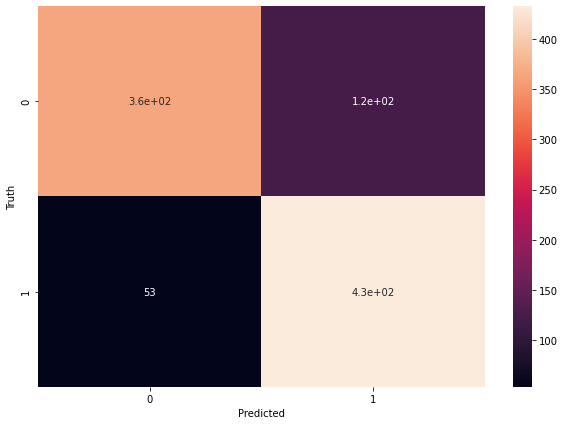

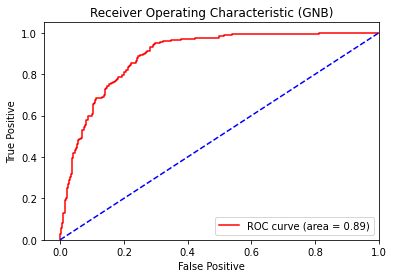

In [21]:
print("Naive Bayes Classification report: \n{}".format(classification_report(y_test, y_gnb)))

print("Naive Bayes Accuracy score: {:.3f}".format(accuracy_score(y_test, y_gnb)))

precision_gnb = precision_score(y_test, y_gnb)
recall_gnb = recall_score(y_test, y_gnb)
F1_gnb = f1_score(y_test, y_gnb)

print("Naive Bayes Precision score: {:.3f}".format(precision_gnb))
print("Naive Bayes Recall score: {:.3f}".format(recall_gnb))
print("Naive Bayes F1 score: {:.3f}".format(F1_gnb))

sens_gnb, spec_gnb = sensitivity_specificity(y_test,y_gnb)
fpr, tpr, _ = roc_curve(y_test,  y_gnb_prob[:,1])
auc_gnb = roc_auc_score(y_test, y_gnb_prob[:,1])

print("Naive Bayes Sensitivity score: {:.3f}".format(sens_gnb))
print("Naive Bayes Specitivity score: {:.3f}".format(spec_gnb))
print("Naive Bayes AUC score: {:.3f}".format(auc_gnb))

print("\nConfusion matrix for Naive Bayes:\n")
cm = confusion_matrix(y_test, y_gnb)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

fig, ax = plt.subplots()
ax.plot(fpr, tpr, color = 'red', label = 'ROC curve (area = %0.2f)' % auc_gnb)
ax.plot([0, 1], [0, 1], color = 'blue', linestyle = '--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive')
ax.set_ylabel('True Positive')
ax.set_title('Receiver Operating Characteristic (GNB)')
ax.legend(loc = "lower right")
plt.show()

In [22]:
start = timer.time()
logistic_reg_model = LogisticRegression(solver = 'lbfgs', random_state = 42)
logistic_reg_model.fit(X_train_std, y_train)
end = timer.time()
print("Logistic Regression completed in {:.3f} seconds".format(end-start))

y_logistic_reg = logistic_reg_model.predict(X_test_std)
y_logistic_reg_prob = logistic_reg_model.predict_proba(X_test_std)

Logistic Regression completed in 0.016 seconds


Logistic Regression Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       487
           1       0.80      0.82      0.81       486

    accuracy                           0.81       973
   macro avg       0.81      0.81      0.81       973
weighted avg       0.81      0.81      0.81       973

Logistic Regression Accuracy score: 0.808
Logistic Regression Precision score: 0.802
Logistic Regression Recall score: 0.817
Logistic Regression F1 score: 0.809
Sensitivity score for LR: 0.817
Specitivity score for LR: 0.799
AUC score for LR: 0.900

Confusion matrix for Logistic Regression:



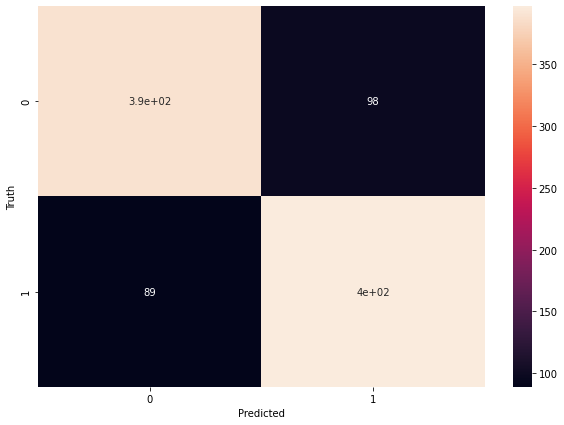

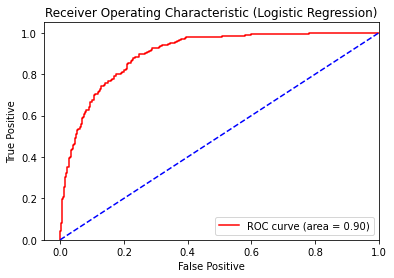

In [23]:
print("Logistic Regression Classification report: \n{}".format(classification_report(y_test, y_logistic_reg)))

print("Logistic Regression Accuracy score: {:.3f}".format(accuracy_score(y_test, y_logistic_reg)))

# calculate precision, recall, and f1 scores
precision_LR = precision_score(y_test, y_logistic_reg)
recall_LR = recall_score(y_test, y_logistic_reg)
F1_LR = f1_score(y_test, y_logistic_reg)

print("Logistic Regression Precision score: {:.3f}".format(precision_LR))
print("Logistic Regression Recall score: {:.3f}".format(recall_LR))
print("Logistic Regression F1 score: {:.3f}".format(F1_LR))

# calculate sensitivity, specificity, and auc
sens_LR, spec_LR = sensitivity_specificity(y_test, y_logistic_reg)
fpr, tpr, _ = roc_curve(y_test,  y_logistic_reg_prob[:,1])
auc_LR = roc_auc_score(y_test, y_logistic_reg_prob[:,1])

print("Sensitivity score for LR: {:.3f}".format(sens_LR))
print("Specitivity score for LR: {:.3f}".format(spec_LR))
print("AUC score for LR: {:.3f}".format(auc_LR))

print("\nConfusion matrix for Logistic Regression:\n")
cm = confusion_matrix(y_test, y_logistic_reg)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

fig, ax = plt.subplots()
ax.plot(fpr, tpr, color = 'red', label = 'ROC curve (area = %0.2f)' % auc_LR)
ax.plot([0, 1], [0, 1], color = 'blue', linestyle = '--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive')
ax.set_ylabel('True Positive')
ax.set_title('Receiver Operating Characteristic (Logistic Regression)')
ax.legend(loc = "lower right")
plt.show()

In [24]:
start = timer.time()
decision_tree_model = DecisionTreeClassifier(random_state = 42)
decision_tree_model.fit(X_train_std, y_train)
end = timer.time()
print("Decision Tree completed in {:.3f} seconds".format(end-start))

y_decision_tree = decision_tree_model.predict(X_test_std)
y_decision_tree_prob = decision_tree_model.predict_proba(X_test_std)

Decision Tree completed in 0.024 seconds


Decision Tree Classification report: 
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       487
           1       0.92      0.92      0.92       486

    accuracy                           0.92       973
   macro avg       0.92      0.92      0.92       973
weighted avg       0.92      0.92      0.92       973

Decision Tree Accuracy score: 0.916
Decision Tree Precision score: 0.916
Decision Tree Recall score: 0.916
Decision Tree F1 score: 0.916
Decision Tree Sensitivity score: 0.916
Decision Tree Specitivity score: 0.916
Decision Tree AUC score: 0.916

Confusion matrix for Decision Tree:



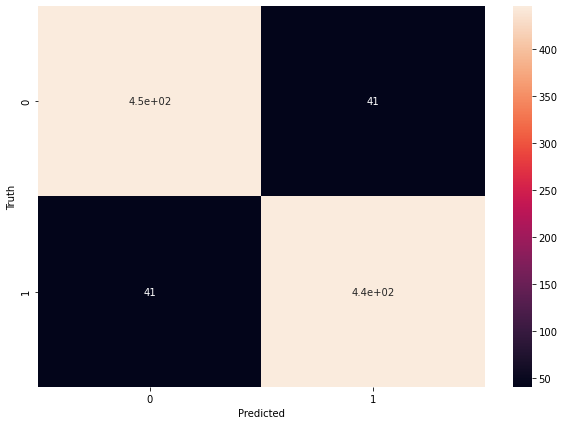

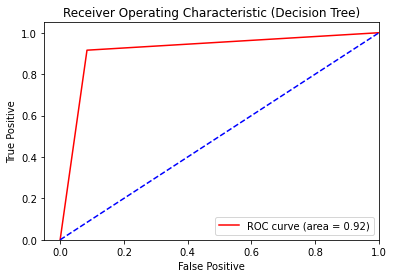

In [25]:
print("Decision Tree Classification report: \n{}".format(classification_report(y_test, y_decision_tree)))

print("Decision Tree Accuracy score: {:.3f}".format(accuracy_score(y_test, y_decision_tree)))

precision_decision_tree = precision_score(y_test, y_decision_tree)
recall_decision_tree = recall_score(y_test, y_decision_tree)
F1_decision_tree = f1_score(y_test, y_decision_tree)

print("Decision Tree Precision score: {:.3f}".format(precision_decision_tree))
print("Decision Tree Recall score: {:.3f}".format(recall_decision_tree))
print("Decision Tree F1 score: {:.3f}".format(F1_decision_tree))

# calculate sensitivity, specificity, and auc
sens_dtree,spec_dtree = sensitivity_specificity(y_test, y_decision_tree)
fpr, tpr, _ = roc_curve(y_test,  y_decision_tree_prob[:, 1])
auc_dtree = roc_auc_score(y_test, y_decision_tree_prob[:, 1])

print("Decision Tree Sensitivity score: {:.3f}".format(sens_dtree))
print("Decision Tree Specitivity score: {:.3f}".format(spec_dtree))
print("Decision Tree AUC score: {:.3f}".format(auc_dtree))

print("\nConfusion matrix for Decision Tree:\n")
cm = confusion_matrix(y_test, y_decision_tree)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

fig, ax = plt.subplots()
ax.plot(fpr, tpr, color = 'red', label = 'ROC curve (area = %0.2f)' % auc_dtree)
ax.plot([0, 1], [0, 1], color = 'blue', linestyle = '--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive')
ax.set_ylabel('True Positive')
ax.set_title('Receiver Operating Characteristic (Decision Tree)')
ax.legend(loc="lower right")
plt.show()

In [26]:
start = timer.time()
randomforest_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
randomforest_model.fit(X_train_std, y_train)
end = timer.time()
print("Random Forest completed in {:.3f} seconds".format(end-start))

y_randomforest = randomforest_model.predict(X_test_std)
y_randomforest_prob = randomforest_model.predict_proba(X_test_std)

Random Forest completed in 0.565 seconds


Random Forest Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       487
           1       0.93      0.96      0.95       486

    accuracy                           0.95       973
   macro avg       0.95      0.95      0.95       973
weighted avg       0.95      0.95      0.95       973

Random Forest Accuracy score: 0.946
Random Forest Precision score: 0.932
Random Forest Recall score: 0.961
Random Forest F1 score: 0.946
Random Forest Sensitivity score: 0.961
Random Forest Specitivity score: 0.930
Random Forest AUC score: 0.990

Confusion matrix for Random Forest:



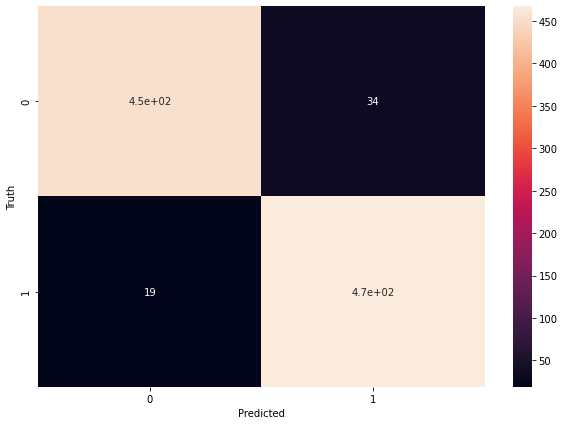

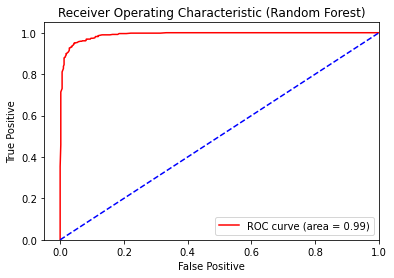

In [27]:
print("Random Forest Classification report: \n{}".format(classification_report(y_test, y_randomforest)))

print("Random Forest Accuracy score: {:.3f}".format(accuracy_score(y_test, y_randomforest)))

precision_randomforest = precision_score(y_test, y_randomforest)
recall_randomforest = recall_score(y_test, y_randomforest)
F1_randomforest = f1_score(y_test, y_randomforest)

print("Random Forest Precision score: {:.3f}".format(precision_randomforest))
print("Random Forest Recall score: {:.3f}".format(recall_randomforest))
print("Random Forest F1 score: {:.3f}".format(F1_randomforest))

# calculate sensitivity, specificity, and auc
sens_ranfor,spec_ranfor = sensitivity_specificity(y_test, y_randomforest)
fpr, tpr, _ = roc_curve(y_test,  y_randomforest_prob[:, 1])
auc_ranfor = roc_auc_score(y_test, y_randomforest_prob[:, 1])

print("Random Forest Sensitivity score: {:.3f}".format(sens_ranfor))
print("Random Forest Specitivity score: {:.3f}".format(spec_ranfor))
print("Random Forest AUC score: {:.3f}".format(auc_ranfor))

print("\nConfusion matrix for Random Forest:\n")
cm = confusion_matrix(y_test, y_randomforest)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

fig, ax = plt.subplots()
ax.plot(fpr, tpr, color = 'red', label = 'ROC curve (area = %0.2f)' % auc_ranfor)
ax.plot([0, 1], [0, 1], color = 'blue', linestyle = '--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive')
ax.set_ylabel('True Positive')
ax.set_title('Receiver Operating Characteristic (Random Forest)')
ax.legend(loc = "lower right")
plt.show()

In [28]:
start = timer.time()
LightGBM_model = LGBMClassifier(n_estimators = 100, random_state = 42)
LightGBM_model.fit(X_train_std, y_train)
end = timer.time()
print("LightGBM completed in {:.3f} seconds".format(end-start))

y_LightGBM = LightGBM_model.predict(X_test_std)
y_LightGBM_prob = LightGBM_model.predict_proba(X_test_std)

LightGBM completed in 0.096 seconds


LightGBM Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       487
           1       0.94      0.95      0.95       486

    accuracy                           0.95       973
   macro avg       0.95      0.95      0.95       973
weighted avg       0.95      0.95      0.95       973

LightGBM Accuracy score: 0.947
LightGBM Precision score: 0.939
LightGBM Recall score: 0.955
LightGBM F1 score: 0.947
Sensitivity score for LGBM: 0.95
Specitivity score for LGBM: 0.94
AUC score for LGBM: 0.99

Confusion matrix for LightGBM:



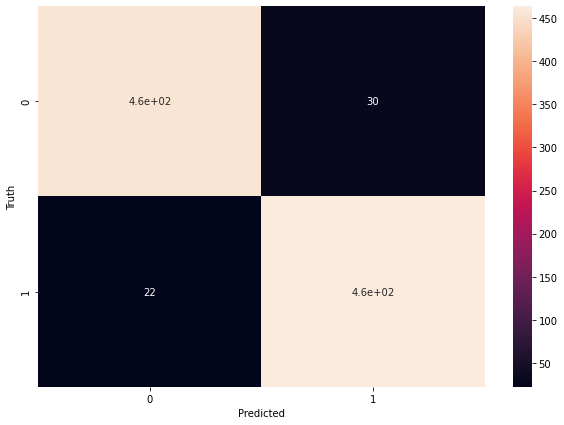

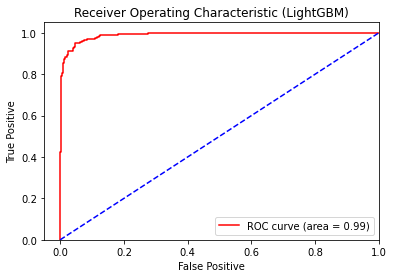

In [29]:
print("LightGBM Classification report: \n{}".format(classification_report(y_test, y_LightGBM)))

print("LightGBM Accuracy score: {:.3f}".format(accuracy_score(y_test, y_LightGBM)))

# calculate precision, recall, and f1 scores
precision_LightGBM = precision_score(y_test, y_LightGBM)
recall_LightGBM = recall_score(y_test, y_LightGBM)
F1_LightGBM = f1_score(y_test, y_LightGBM)

print("LightGBM Precision score: {:.3f}".format(precision_LightGBM))
print("LightGBM Recall score: {:.3f}".format(recall_LightGBM))
print("LightGBM F1 score: {:.3f}".format(F1_LightGBM))

# calculate sensitivity, specificity, and auc
sens_lgbm, spec_lgbm = sensitivity_specificity(y_test, y_LightGBM)
fpr, tpr, _ = roc_curve(y_test,  y_LightGBM_prob[:, 1])
auc_lgbm = roc_auc_score(y_test, y_LightGBM_prob[:, 1])

print("Sensitivity score for LGBM: {:.2f}".format(sens_lgbm))
print("Specitivity score for LGBM: {:.2f}".format(spec_lgbm))
print("AUC score for LGBM: {:.2f}".format(auc_lgbm))

print("\nConfusion matrix for LightGBM:\n")
cm = confusion_matrix(y_test, y_LightGBM)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

fig, ax = plt.subplots()
ax.plot(fpr, tpr, color = 'red', label = 'ROC curve (area = %0.2f)' % auc_lgbm)
ax.plot([0, 1], [0, 1], color = 'blue', linestyle = '--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive')
ax.set_ylabel('True Positive')
ax.set_title('Receiver Operating Characteristic (LightGBM)')
ax.legend(loc = "lower right")
plt.show()

In [30]:
start = timer.time()
XGBoost_model = XGBClassifier(objective = "binary:logistic", random_state = 42)
XGBoost_model.fit(X_train_std, y_train)
end = timer.time()
print("XGBoost completed in {:.3f} seconds".format(end-start))

y_XGBoost = XGBoost_model.predict(X_test_std)
y_XGBoost_prob = XGBoost_model.predict_proba(X_test_std)

C:\Users\adnan\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:34:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost completed in 1.337 seconds


C:\Users\adnan\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


XGBoost Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       487
           1       0.95      0.97      0.96       486

    accuracy                           0.96       973
   macro avg       0.96      0.96      0.96       973
weighted avg       0.96      0.96      0.96       973

XGBoost Accuracy score: 0.957
XGBoost Precision score: 0.949
XGBoost Recall score: 0.965
XGBoost F1 score: 0.957
XGBoost Sensitivity score: 0.965
XGBoost Specitivity score: 0.949
XGBoost AUC score: 0.992

Confusion matrix for XGBoost:



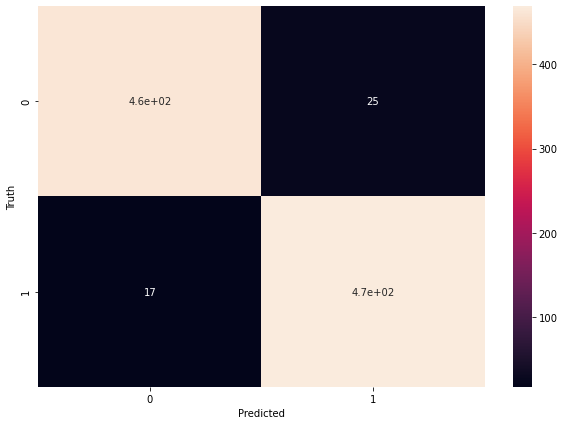

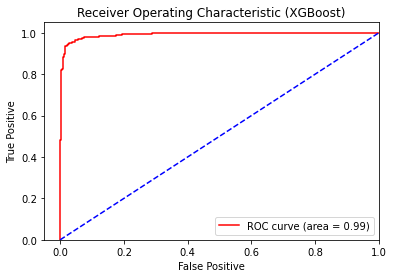

In [31]:
print("XGBoost Classification report: \n{}".format(classification_report(y_test, y_XGBoost)))

print("XGBoost Accuracy score: {:.3f}".format(accuracy_score(y_test, y_XGBoost)))

precision_XGBoost = precision_score(y_test, y_XGBoost)
recall_XGBoost = recall_score(y_test, y_XGBoost)
F1_XGBoost = f1_score(y_test, y_XGBoost)

print("XGBoost Precision score: {:.3f}".format(precision_XGBoost))
print("XGBoost Recall score: {:.3f}".format(recall_XGBoost))
print("XGBoost F1 score: {:.3f}".format(F1_XGBoost))

sens_xgb, spec_xgb = sensitivity_specificity(y_test, y_XGBoost)
fpr, tpr, _ = roc_curve(y_test,  y_XGBoost_prob[:, 1])
auc_xgb = roc_auc_score(y_test, y_XGBoost_prob[:, 1])

print("XGBoost Sensitivity score: {:.3f}".format(sens_xgb))
print("XGBoost Specitivity score: {:.3f}".format(spec_xgb))
print("XGBoost AUC score: {:.3f}".format(auc_xgb))

print("\nConfusion matrix for XGBoost:\n")
cm = confusion_matrix(y_test, y_XGBoost)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

fig, ax = plt.subplots()
ax.plot(fpr, tpr, color = 'red', label = 'ROC curve (area = %0.2f)' % auc_xgb)
ax.plot([0, 1], [0, 1], color = 'blue', linestyle = '--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive')
ax.set_ylabel('True Positive')
ax.set_title('Receiver Operating Characteristic (XGBoost)')
ax.legend(loc = "lower right")
plt.show()

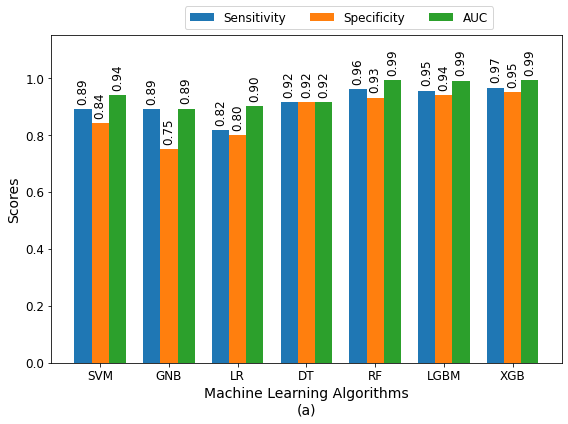

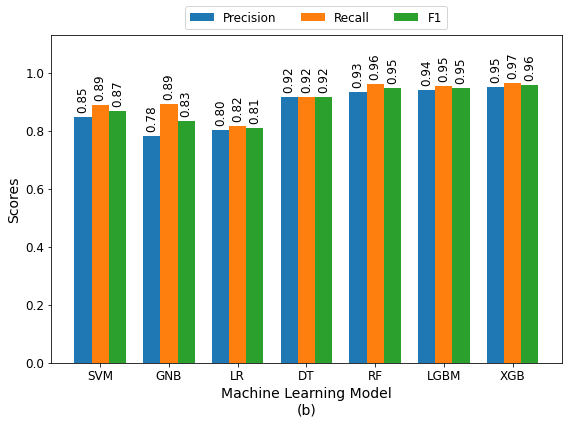

In [32]:
ml_algorithms = ['SVM', 'GNB', 'LR', 'DT', 'RF', 'LGBM', 'XGB']
sens_all = [sens_svm, sens_gnb, sens_LR, sens_dtree, sens_ranfor, sens_lgbm, sens_xgb]
spec_all = [spec_svm, spec_gnb, spec_LR, spec_dtree, spec_ranfor, spec_lgbm, spec_xgb]
auc_all = [auc_svm, auc_gnb, auc_LR, auc_dtree, auc_ranfor, auc_lgbm, auc_xgb]

precision_all = [precision_svm, precision_gnb, precision_LR, precision_decision_tree, precision_randomforest, precision_LightGBM, precision_XGBoost]
recall_all = [recall_svm, recall_gnb, recall_LR, recall_decision_tree, recall_randomforest, recall_LightGBM, recall_XGBoost]
F1_all = [F1_svm, F1_gnb, F1_LR, F1_decision_tree, F1_randomforest, F1_LightGBM, F1_XGBoost]

#Code adapted from ebauch on Github
#https://github.com/matplotlib/matplotlib/issues/12386
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    fontsize=12,
                    rotation=90,
                    ha='center', va='bottom')

#Code modified from python graph galley
#https://www.python-graph-gallery.com/11-grouped-barplot
width = 0.25  
r1 = np.arange(len(ml_algorithms)) 
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]

fig, ax = plt.subplots(figsize=(8,6))
bar1 = ax.bar(r1, sens_all, width, label='Sensitivity')
bar2 = ax.bar(r2, spec_all, width, label='Specificity')
bar3 = ax.bar(r3, auc_all, width, label='AUC')

ax.set_ylim([0,1.15])
ax.set_ylabel('Scores',fontsize=14)

ax.set_xticks(r2)
ax.set_xticklabels(ml_algorithms)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.set_xlabel("Machine Learning Algorithms\n(a)",fontsize = 14)
ax.legend(loc = 'lower left', ncol = 3, bbox_to_anchor = (0.25,1), fontsize = 12)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
fig.savefig("AUC_Benchmark.pdf", bbox_inches = 'tight')
plt.show()


fig, ax = plt.subplots(figsize=(8,6))
bar1 = ax.bar(r1, precision_all, width, label = 'Precision')
bar2 = ax.bar(r2, recall_all, width, label = 'Recall')
bar3 = ax.bar(r3, F1_all, width, label = 'F1')

ax.set_ylim([0,1.13])
ax.set_ylabel('Scores',fontsize = 14)

ax.set_xticks(r2)
ax.set_xticklabels(ml_algorithms)
ax.tick_params(axis = 'both', which='major', labelsize = 12)
ax.set_xlabel("Machine Learning Model\n(b)",fontsize = 14)
ax.legend(loc = 'lower left',ncol=3,bbox_to_anchor = (0.25, 1), fontsize = 12)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
fig.savefig("F1_Benchmark.pdf", bbox_inches='tight')
plt.show()

<ipython-input-33-4f8be7d07c81>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(feature_names[RF_tree_sort_idx])
C:\Users\adnan\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-33-4f8be7d07c81>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(feature_names[XGB_tree_sort_idx])


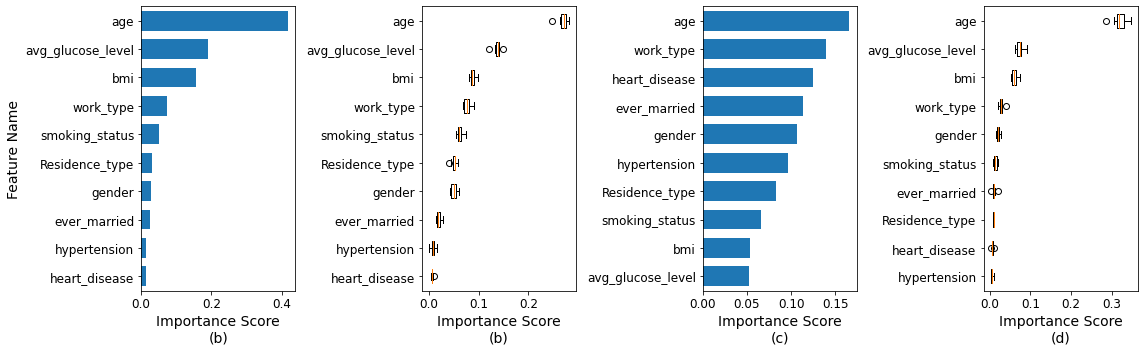

In [33]:
#Random Forest Feature Importance
feature_names = df.columns[:-1].to_numpy()
RF_perm_imp = permutation_importance(randomforest_model, X_test_std, y_test, n_repeats = 10, random_state = 42)
RF_perm_sort_idx = RF_perm_imp.importances_mean.argsort()

RF_tree_sort_idx = np.argsort(randomforest_model.feature_importances_)
RF_indices = np.arange(0, len(randomforest_model.feature_importances_)) + 0.5

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 5))
ax1.barh(RF_indices, randomforest_model.feature_importances_[RF_tree_sort_idx], height = 0.7)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax1.set_xlabel("Importance Score\n(b)", fontsize = 14)
ax1.set_ylabel("Feature Name", fontsize = 14)
ax1.set_yticklabels(feature_names[RF_tree_sort_idx])
ax1.set_yticks(RF_indices)
ax1.set_ylim((0, len(randomforest_model.feature_importances_)))
ax2.boxplot(RF_perm_imp.importances[RF_perm_sort_idx].T, vert = False, labels = feature_names[RF_perm_sort_idx])
ax2.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax2.set_xlabel("Importance Score\n(b)", fontsize = 14)

#XGBoost Feature Priority
XGB_perm_imp = permutation_importance(XGBoost_model, X_test_std, y_test, n_repeats = 10, random_state = 42)
XGB_perm_sort_idx = XGB_perm_imp.importances_mean.argsort()

XGB_tree_sort_idx = np.argsort(XGBoost_model.feature_importances_)
XGB_indices = np.arange(0, len(XGBoost_model.feature_importances_)) + 0.5

ax3.barh(XGB_indices, XGBoost_model.feature_importances_[XGB_tree_sort_idx], height = 0.7)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax3.set_xlabel("Importance Score\n(c)", fontsize = 14)
ax3.set_yticklabels(feature_names[XGB_tree_sort_idx])
ax3.set_yticks(XGB_indices)
ax3.set_ylim((0, len(XGBoost_model.feature_importances_)))
ax4.boxplot(XGB_perm_imp.importances[XGB_perm_sort_idx].T, vert = False, labels = feature_names[XGB_perm_sort_idx])
ax4.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax4.set_xlabel("Importance Score\n(d)", fontsize = 14)
fig.tight_layout()
fig.savefig("feature_importance.pdf", bbox_inches = 'tight')
plt.show()